In [0]:
from google.colab import files
files.upload()

In [0]:
!mkdir /root/.kaggle
!mv kaggle.json /root/.kaggle/
!kaggle competitions download -c tgs-salt-identification-challenge
!unzip -q train.zip
!unzip -q test.zip
!rm train.zip test.zip

  0% 0.00/322k [00:00<?, ?B/s]
100% 322k/322k [00:00<00:00, 49.6MB/s]
  0% 0.00/264k [00:00<?, ?B/s]
100% 264k/264k [00:00<00:00, 77.2MB/s]
  0% 0.00/922k [00:00<?, ?B/s]
100% 922k/922k [00:00<00:00, 60.6MB/s]
 99% 161M/163M [00:03<00:00, 37.9MB/s]
100% 163M/163M [00:03<00:00, 47.9MB/s]
 90% 34.0M/37.9M [00:00<00:00, 20.3MB/s]
100% 37.9M/37.9M [00:00<00:00, 48.6MB/s]


### TGT Salt Classification Challenge


In [1]:
import numpy as np
from keras.preprocessing.image import img_to_array
import cv2
def rle_to_output(x):
  if type(x)!=np.float:
    x = list(map(int, x.split(' ')))
    out = np.zeros(101*101,dtype=np.int64)
    for i in range(0,len(x),2):
      out[ x[i]-1:x[i+1]+x[i]-1 ] = 1
    return np.reshape(np.array(out),(101,101)).T
  else:
    return np.zeros((101,101),dtype=np.int64)

Using TensorFlow backend.


In [2]:
import glob
import pandas as pd

data = pd.read_csv('train.csv')
depths = pd.read_csv('depths.csv')
data = pd.merge(data,depths,on='id',how='left')
X = data.id.apply(lambda x: "masks/"+str(x)+'.png')
Y = data.rle_mask.apply(rle_to_output)
Z = data.z
data.head(5)

,id,rle_mask,z
0,575d24d81d,NaN,843
1,a266a2a9df,5051 5151,794
2,75efad62c1,9 93 109 94 210 94 310 95 411 95 511 96 612 96...,468
3,34e51dba6a,48 54 149 54 251 53 353 52 455 51 557 50 659 4...,727
4,4875705fb0,1111 1 1212 1 1313 1 1414 1 1514 2 1615 2 1716...,797


### Basic Visualization

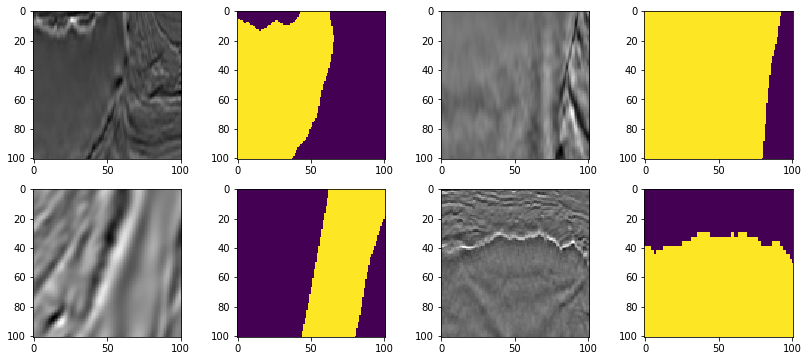

In [3]:
import matplotlib.pyplot as plt
import cv2
%matplotlib inline
fig,ax = plt.subplots(nrows=2,ncols=4,figsize=(14,6))
indexs=[15,511,1130,3452]
for index,l in zip(indexs,[(0,0),(0,2),(1,0),(1,2)]):
  im = cv2.imread('images/{}.png'.format(data.iloc[index].id))
  ax[l[0]][l[1]].imshow(im)
  ax[l[0]][l[1]+1].imshow(Y.values[index])

In [4]:
all_images = glob.glob('masks/*')
print(len(all_images), X.shape)

IMG_DIM = (128,128,3)

from keras.preprocessing.image import img_to_array, load_img, ImageDataGenerator
imgs = np.array([ img_to_array( load_img(file, target_size = IMG_DIM ) ) for file in X.values ])
Y = np.array([ np.expand_dims(cv2.resize( img_to_array(x), (128,128), interpolation = cv2.INTER_AREA ),axis=-1) for x in Y.values ])

print(imgs.shape,Y.shape,Z.shape)

4000 (4000,)
(4000, 128, 128, 3) (4000, 128, 128, 1) (4000,)


In [0]:
from sklearn.model_selection import train_test_split
X_train,X_val,Y_train,Y_val = train_test_split(imgs,Y,test_size=0.2, )

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(X_train, Y_train, batch_size=32)
val_generator = val_datagen.flow(X_val, Y_val, batch_size=32)

### Implementing a Fully Convolutional Network called UNET for Image Segmentation

In [6]:
from keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from keras import optimizers
from keras.applications import VGG16
from keras.models import Model

vgg = VGG16(weights='imagenet',include_top=False, input_shape=IMG_DIM)
vgg.layers.pop()
vgg.trainable=False
for layer in vgg.layers[:-3]:
    layer.trainable = False

def conv2d_block( input_tensor, n_filters, kernel_size = (3,3)):
  "Add 2 conv layer"
  x = Conv2D(filters=n_filters, kernel_size=kernel_size, kernel_initializer='he_normal', 
             padding='same',activation="relu")(input_tensor)
  
  x = Conv2D(filters=n_filters, kernel_size=kernel_size, kernel_initializer='he_normal', 
             padding='same',activation="relu")(x)
  return x

u1 = Conv2DTranspose(512, (3, 3), strides = (2, 2), padding = 'same')(vgg.get_layer('block5_conv3').output)
u1 = concatenate([u1,vgg.get_layer('block4_conv3').output])
c1 = conv2d_block(u1, 512)


u2 = Conv2DTranspose(256, (3, 3), strides = (2, 2), padding = 'same')(c1)
u2 = concatenate([u2,vgg.get_layer('block3_conv3').output])
c2 = conv2d_block(u2, 256)

u3 = Conv2DTranspose(128, (3, 3), strides = (2, 2), padding = 'same')(c2)
u3 = concatenate([u3,vgg.get_layer('block2_conv2').output])
c3 = conv2d_block(u3, 128)

u4 = Conv2DTranspose(64, (3, 3), strides = (2, 2), padding = 'same')(c3)
u4 = concatenate([u4,vgg.get_layer('block1_conv2').output])
c4 = conv2d_block(u4, 64)

output = Conv2D(1, (1, 1), activation='sigmoid')(c4)


unet = Model(vgg.input, output)
  

unet.compile(optimizer=optimizers.Adam(lr=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

unet.summary()

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 128, 128, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 128, 128, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 64, 64, 64)   0           block1_conv2[0][0]               
_____________________________________

In [7]:
layers = [(layer, layer.name, layer.trainable) for layer in unet.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

,Layer Type,Layer Name,Layer Trainable
0,<keras.engine.input_layer.InputLayer object at...,input_1,False
1,<keras.layers.convolutional.Conv2D object at 0...,block1_conv1,False
2,<keras.layers.convolutional.Conv2D object at 0...,block1_conv2,False
3,<keras.layers.pooling.MaxPooling2D object at 0...,block1_pool,False
4,<keras.layers.convolutional.Conv2D object at 0...,block2_conv1,False
5,<keras.layers.convolutional.Conv2D object at 0...,block2_conv2,False
6,<keras.layers.pooling.MaxPooling2D object at 0...,block2_pool,False
7,<keras.layers.convolutional.Conv2D object at 0...,block3_conv1,False
8,<keras.layers.convolutional.Conv2D object at 0...,block3_conv2,False
9,<keras.layers.convolutional.Conv2D object at 0...,block3_conv3,False


In [8]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

model_checkpoint  = ModelCheckpoint('model_best_checkpoint.h5', save_best_only=True, monitor='val_loss', mode='min', verbose=2)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode='min')

callback_list = [model_checkpoint,early_stopping]

history = unet.fit_generator(train_generator, steps_per_epoch=20, epochs=300,
                              validation_data=val_generator, validation_steps=15, 
                              verbose=1,callbacks=callback_list)

Instructions for updating:
Use tf.cast instead.
Epoch 1/300
20/20 [==============================] - 20s 990ms/step - loss: 0.2676 - acc: 0.9176 - val_loss: 0.0265 - val_acc: 0.9909

Epoch 00001: val_loss improved from inf to 0.02651, saving model to model_best_checkpoint.h5
Epoch 2/300
20/20 [==============================] - 9s 470ms/step - loss: 0.0152 - acc: 0.9925 - val_loss: 0.0090 - val_acc: 0.9939

Epoch 00002: val_loss improved from 0.02651 to 0.00900, saving model to model_best_checkpoint.h5
Epoch 3/300
20/20 [==============================] - 10s 477ms/step - loss: 0.0080 - acc: 0.9939 - val_loss: 0.0070 - val_acc: 0.9942

Epoch 00003: val_loss improved from 0.00900 to 0.00700, saving model to model_best_checkpoint.h5
Epoch 4/300
20/20 [==============================] - 9s 468ms/step - loss: 0.0072 - acc: 0.9936 - val_loss: 0.0068 - val_acc: 0.9937

Epoch 00004: val_loss improved from 0.00700 to 0.00676, saving model to model_best_checkpoint.h5
Epoch 5/300
20/20 [===========

In [9]:
submission = pd.read_csv('sample_submission.csv',usecols=['id'])
submission.head()

,id
0,155410d6fa
1,78b32781d1
2,63db2a476a
3,17bfcdb967
4,7ea0fd3c88


In [10]:
test_images = [ 'images/{}.png'.format(i) for i in submission.id.values ]
test_images = np.array([ img_to_array( load_img(file, target_size = IMG_DIM ) ) for file in test_images ])/255.0
test_images = unet.predict(test_images)
test_images.shape

(18000, 128, 128, 1)

In [0]:
def process_output(out):
    im = cv2.resize(out, (101,101), interpolation = cv2.INTER_AREA)
    return (np.squeeze(im)>0.5)*1

def rle_encode(im):
  im = np.reshape(im,(101*101))
  pixels = im.flatten(order = 'F')
  pixels = np.concatenate([[0], pixels, [0]])
  runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
  runs[1::2] -= runs[::2]
  return ' '.join(str(x) for x in runs)

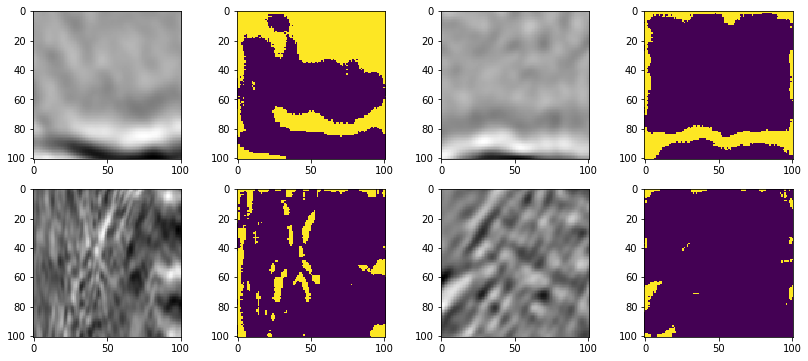

In [15]:
fig,ax = plt.subplots(nrows=2,ncols=4,figsize=(14,6))
indexs=[145,678,1456,13453]
for index,l in zip(indexs,[(0,0),(0,2),(1,0),(1,2)]):
  im = cv2.imread("images/{}.png".format(submission.iloc[index].id))
  ax[l[0]][l[1]].imshow(im)
  ax[l[0]][l[1]+1].imshow(process_output(outputs[index]))

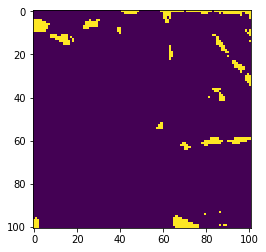

In [16]:
temp = np.array([ img_to_array( load_img('images/'+data.iloc[15].id+'.png', target_size = IMG_DIM ) ) ])/255.
temp = unet.predict(temp)
plt.imshow(process_output(temp[0]))

In [18]:
submission['rle_mask'] = [ rle_encode(process_output(o)) for o in outputs ]
submission.head()

,id,rle_mask
0,155410d6fa,1 6928 6940 89 7044 86 7147 81 7254 75 7356 72...
1,78b32781d1,1 15 17 26 52 62 119 1 121 6 130 12 153 13 173...
2,63db2a476a,1 151 154 8 165 25 196 3 200 25 230 11 245 5 2...
3,17bfcdb967,1 210 212 33 246 9 259 51 314 4 321 9 333 4 34...
4,7ea0fd3c88,1 34 42 5 57 3 62 10 74 35 113 3 118 17 159 2 ...


In [0]:
submission.to_csv('submission.csv',index=False)

In [20]:
!kaggle competitions submit -c tgs-salt-identification-challenge -f submission.csv -m "simple unet 16 may"

100% 37.7M/37.7M [00:05<00:00, 6.95MB/s]
Successfully submitted to TGS Salt Identification Challenge